## Финальное соревнование

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

В данном задании вас ждет неизвестная зависимость. Ваша основная задача: **построить две лучших модели**, минимизирующих среднеквадратичную ошибку (MSE):
1. На первую модель не налагается ограничений.
2. Вторая модель должна быть **линейной**, т.е. представлять собой линейную комбинацию признаков плюс свободный член: $\boldsymbol{w}^{\top}\boldsymbol{x} + b$. При этом __вы можете использовать базовые математические операции для преобразования признаков__: np.exp, np.log, np.pow (полный список доступен в [документации](https://numpy.org/doc/stable/reference/routines.math.html)), а также линейные операции над ними (сумма, умножение на число и пр.). Для преобразования признаков вам будет необходимо написать функцию `my_transformation`. __Кол-во параметров (весов) используемых второй моделью не должно превышать 15 (включая свободный член).__

Настоятельно рекомендуем написать код "с нуля", лишь поглядывая на готовые примеры, а не просто "скопировать-вставить". Это поможет вам в будущем писать код более уверенно

In [3]:
import os
import json

import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Загрузка данных происходит ниже. Если она не срабатывает, самостоятельно скачайте файл `hw_final_open_data.npy` и положите его в ту же директорию, что и ноутбук.

In [4]:
# !wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_yandex_ml_trainings/homeworks/assignment_final/hw_final_open_data.npy -O hw_final_open_data.npy
# !wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_yandex_ml_trainings/homeworks/assignment_final/hw_final_open_target.npy -O hw_final_open_target.npy

In [5]:
assert os.path.exists('hw_final_open_data.npy'), 'Please, download `hw_final_open_data.npy` and place it in the working directory'
assert os.path.exists('hw_final_open_target.npy'), 'Please, download `hw_final_open_target.npy` and place it in the working directory'
data = np.load('hw_final_open_data.npy', allow_pickle=False)
target = np.load('hw_final_open_target.npy', allow_pickle=False)

Разбивка на `train` и `val` опциональна и сделана для вашего удобства.

In [4]:
train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.1, shuffle=True)

### Модель №1
Напоминаем, в первой части задания ваша основная задача – получить наилучший результат без ограничений на модель. Сдаваться будут только предсказания модели.

Пример с использованием Random Forest доступен ниже.

In [5]:
rf = RandomForestRegressor()
rf.fit(train_x, train_y)

print(
    f'train mse =\t {mean_squared_error(np.round(rf.predict(train_x), 2), np.round(train_y)):.5f}',
    f'validation mse = {mean_squared_error(np.round(rf.predict(valid_x)), np.round(valid_y)):.5f}',
    sep='\n'
)

train mse =	 0.10390
validation mse = 0.32500


In [6]:
def validate(model, train, valid, log=True):
    t = mean_squared_error(np.round(model.predict(train[0]), 2), np.round(train[1]))
    v = mean_squared_error(np.round(model.predict(valid[0])), np.round(valid[1]))
    if log:
        print(
            f'train mse =\t {t:.5f}',
            f'validation mse = {v:.5f}',
            sep='\n'
        )
    return t, v

---
### Экспериментируем

Познакомимся с данными

In [7]:
train_x.shape, train_y.shape

((720, 7), (720,))

In [8]:
train_x[0], train_y[0]

(array([-0.56681676, -0.48369092, -0.56863048, -0.42573488, -0.53331366,
        -0.30305042, -0.57543757]),
 np.float64(0.3276571303918419))

Признаков немного, можно посмотреть на то, как таргет зависит от каждого

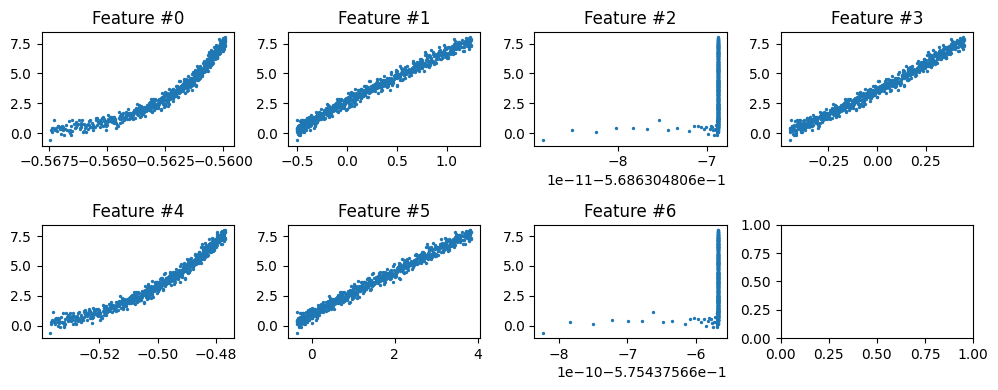

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(10, 4))

for feature in range(train_x.shape[1]):
    i = feature // 4
    j = feature % 4
    ax[i, j].scatter(train_x[:, feature], train_y, s=2)
    ax[i, j].set_title(f'Feature #{feature}')

plt.tight_layout()
plt.show()

Видно, что 0-ая и 4-ая фичи имеют полиномиальную зависимость. Фичи 1, 3 и 5 - близкие к линейной. А вот с фичами 2 и 6 что-то непонятное. Данные собраны возле одного значения и имеют большие хвосты слева. Давайте посмотрим на них отдельно

In [10]:
feature_2 = train_x[:, 2]

m, M = np.percentile(feature_2, 10), np.percentile(feature_2, 100)
print(m, M)

-0.5686304806687642 -0.5686304806687642


In [11]:
np.mean(feature_2), np.std(feature_2)

(np.float64(-0.5686304806689223), np.float64(1.3084150601615882e-12))

Это практически константный признак. Взглянем на 6-ой признак

In [12]:
feature_6 = train_x[:, 6]

np.mean(feature_6), np.std(feature_6)

(np.float64(-0.5754375665704126), np.float64(1.7545094918998147e-11))

Аналогично. Попробуем отмасштабировать данные

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

pipe = Pipeline([
    ('min_max_scale', MinMaxScaler((0, 1)))
])
new_train = pipe.fit_transform(train_x)

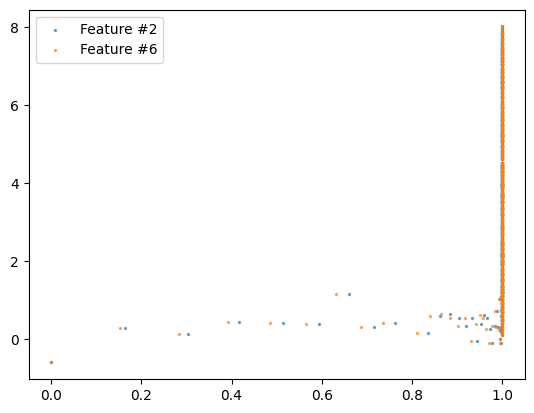

In [14]:
plt.scatter(new_train[:, 2], train_y, s=2, label=f'Feature #{2}', alpha=0.6)
plt.scatter(new_train[:, 6], train_y, s=2, label=f'Feature #{6}', alpha=0.6)
plt.legend()
plt.show()

Я не теряю надежды, что в этих данных хоть что-то есть. Попробуем убрать длинные хвосты

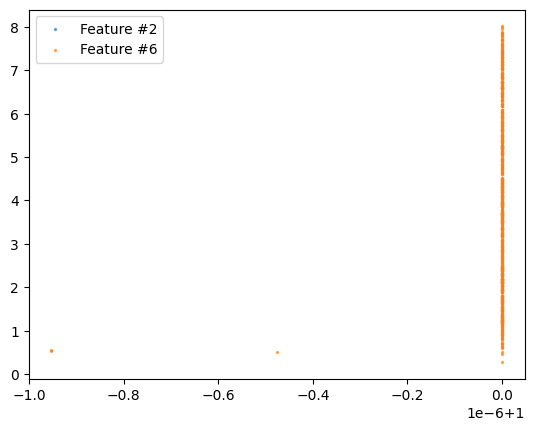

In [15]:
feature_2 = new_train[:, 2]
m2 = np.percentile(feature_2, 9)
feature_6 = new_train[:, 6]
m6 = np.percentile(feature_6, 9)
plt.scatter(feature_2[feature_2 > m2], train_y[feature_2 > m2], s=2, label=f'Feature #{2}', alpha=0.6)
plt.scatter(feature_6[feature_6 > m6], train_y[feature_6 > m6], s=2, label=f'Feature #{6}', alpha=0.6)
plt.legend()
plt.show()

Безнадёжно, это константые признаки. Выкидываем (у модели и так есть bias, не будем перегружать её)

In [16]:
from sklearn.feature_selection import VarianceThreshold

pipe = Pipeline([
    ('variance_threshold', VarianceThreshold(1e-10)),
])

new_train = pipe.fit_transform(train_x)
new_valid = pipe.fit_transform(valid_x)
assert new_train.shape[1] == 5  # выбросили два признака

model = Ridge()
model.fit(new_train, train_y)
_ = validate(model, (new_train, train_y), (new_valid, valid_y))

train mse =	 0.18113
validation mse = 0.31250


Качество уже чуть лучше, чем у случайного леса!

Давайте посмотрим, что можно сделать с полиномиальными признаками. Для этого возьмём каждый признак отдельно и попробуем перебрать полиномы разной степени и взглянуть, обучить линейную модель предсказывать таргет исключительно по этому признаку. Обучать будем LASSO - так как он умеет прореживать веса, это полезно, если используются не все степени полинома

In [17]:
pipe = Pipeline([
    ('variance_threshold', VarianceThreshold(1e-10)),
    ('min_max_scale', MinMaxScaler((0, 1))),
])
new_train = pipe.fit_transform(train_x)
new_valid = pipe.fit_transform(valid_x)
assert new_train.shape[1] == 5

In [ ]:
def make_poly(X, degree):
    if len(X.shape) == 1:
        X = X[:, np.newaxis]
    return np.concatenate([X ** d for d in range(1, degree + 1)], axis=1)

best_poly = []
best_models = []
for feature in range(5):
    score = 10**10
    best_degree = None
    best_model = None
    for degree in range(1, 4):
        tmp_data_tr = make_poly(new_train[:, feature], degree)
        tmp_data_vl = make_poly(new_valid[:, feature], degree)
        model = Lasso(alpha=0.5, max_iter=5000)
        model.fit(tmp_data_tr, train_y)
        tr, vl = validate(model, (tmp_data_tr, train_y), (tmp_data_vl, valid_y), log=False)
        if vl < score:
            score = vl
            best_degree = degree
            best_model = model
    print(f'Feature #{feature}, Best degree: {best_degree}, Weights: {best_model.coef_}')
    best_poly.append(best_degree)
    best_models.append(best_model)

Feature #0, Best degree: 3, Weights: [0.         0.         1.83343691]
Feature #1, Best degree: 1, Weights: [1.61736235]
Feature #2, Best degree: 2, Weights: [0.         1.53787545]
Feature #3, Best degree: 2, Weights: [0.         1.75046967]
Feature #4, Best degree: 1, Weights: [1.60768403]


Как видно из весов, 0-ой признак нужно возвести в куб, а 2-ой и 3-ий в квадрат, и этого будет достаточно

In [19]:
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold

def poly(X):
    X_new = X.copy()
    X_new[:, 0] = X[:, 0] ** 3
    X_new[:, 2] = X[:, 2] ** 2
    X_new[:, 3] = X[:, 3] ** 2
    return X_new

pipe = Pipeline([
    ('variance_threshold', VarianceThreshold(1e-10)),
    ('min_max_scale', MinMaxScaler((0, 1))),
    ('poly_features', FunctionTransformer(poly)),
])

new_train = pipe.fit_transform(train_x)
new_valid = pipe.fit_transform(valid_x)

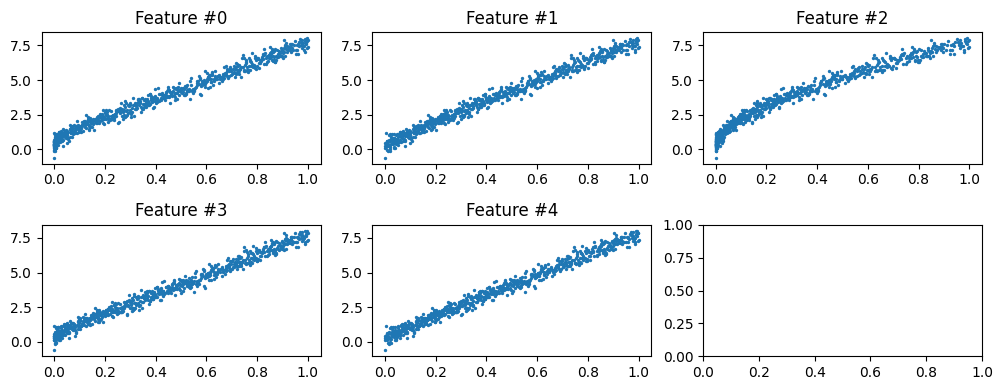

In [20]:
nrows = 2
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 4))

for feature in range(new_train.shape[1]):
    i = feature // ncols
    j = feature % ncols
    ax[i, j].scatter(new_train[:, feature], train_y, s=2)
    ax[i, j].set_title(f'Feature #{feature}')

plt.tight_layout()
plt.show()

У меня есть подозрение, что для признакоы должна быть нецелые степени. Давайте проверим

In [21]:
pipe = Pipeline([
    ('variance_threshold', VarianceThreshold(1e-10)),
    ('min_max_scale', MinMaxScaler((0, 2))),
])
new_train = pipe.fit_transform(train_x)
new_valid = pipe.transform(valid_x)
assert new_train.shape[1] == 5

def make_poly(X, degree):
    if len(X.shape) == 1:
        X = X[:, np.newaxis]
    return X ** degree

best_poly = []
best_models = []
for feature in range(5):
    score = 10**10
    best_degree = None
    best_model = None
    for degree in np.linspace(1, 3, num=1000):
        tmp_data_tr = make_poly(new_train[:, feature], degree)
        tmp_data_vl = make_poly(new_valid[:, feature], degree)
        model = LinearRegression()
        model.fit(tmp_data_tr, train_y)
        tr, vl = validate(model, (tmp_data_tr, train_y), (tmp_data_vl, valid_y), log=False)
        if vl < score:
            score = vl
            best_degree = degree
            best_model = model
    print(f'Feature #{feature}, Best degree: {best_degree}, Score: {score}')
    best_poly.append(best_degree)
    best_models.append(best_model)

Feature #0, Best degree: 2.8958958958958956, Score: 0.25
Feature #1, Best degree: 1.02002002002002, Score: 0.3125
Feature #2, Best degree: 1.1741741741741742, Score: 0.2625
Feature #3, Best degree: 1.970970970970971, Score: 0.2625
Feature #4, Best degree: 1.0, Score: 0.3125


Пробуем

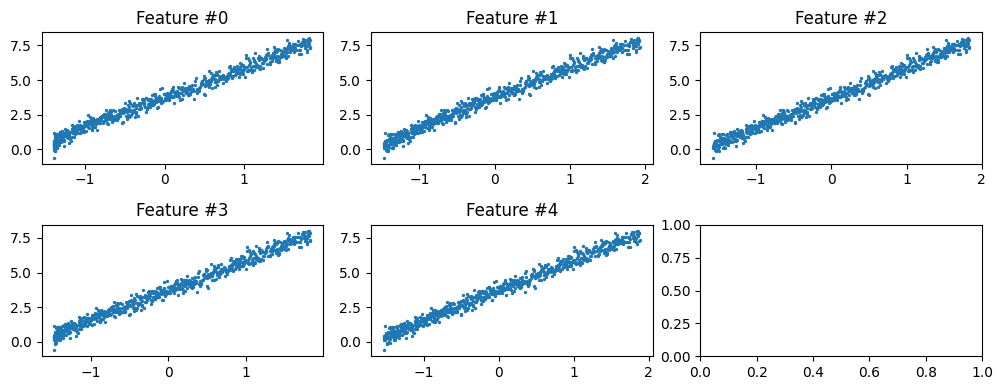

In [22]:
def poly(X):
    X_new = X.copy()
    for i in range(5):
        X_new[:, i] = np.sign(X[:, i]) * (np.abs(X[:, i]) ** best_poly[i])
    return X_new

pipe = Pipeline([
    ('variance_threshold', VarianceThreshold(1e-10)),
    ('min_max_scale', MinMaxScaler((0, 1))),
    ('poly_features', FunctionTransformer(poly)),
    ('scale', StandardScaler())
])

new_train = pipe.fit_transform(train_x)
new_valid = pipe.transform(valid_x)

nrows = 2
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 4))

for feature in range(new_train.shape[1]):
    i = feature // ncols
    j = feature % ncols
    ax[i, j].scatter(new_train[:, feature], train_y, s=2)
    ax[i, j].set_title(f'Feature #{feature}')

plt.tight_layout()
plt.show()

In [79]:
pipe[3].scale_

array([0.31092565, 0.29343886, 0.29345891, 0.30286409, 0.29209942])

---

In [ ]:
import numpy as np

def manual_pipeline_transform(X):
    feature_matrix = np.delete(X, [2, 6], axis=1)

    data_min_ = np.array([-0.56745416, -0.50726948, -0.44891025, -0.53678504, -0.36786881])
    data_max_ = np.array([-0.55991845,  1.25029283,  0.44817312, -0.47689872,  3.8536616])

    X = (X - data_min_) / (data_max_ - data_min_)

    best_poly = [
        np.float64(2.8958958958958956),
        np.float64(1.02002002002002),
        np.float64(1.1741741741741742),
        np.float64(1.970970970970971),
        np.float64(1.0)
    ]
    for i in range(5):
        X[:, i] = np.sign(X[:, i]) * (np.abs(X[:, i]) ** best_poly[i])

    mean_ = np.array([0.42779629, 0.43060812, 0.45941949, 0.44224107, 0.44707574])
    scale_ = np.array([0.31092565, 0.29343886, 0.29345891, 0.30286409, 0.29209942])

    X = (X - mean_) / scale_

    return X

---

И тут я заметил, что все признаки одинаковые. В том смысле, что даже если усреднять - толку не будет, это один и тот же признак, который кто-то прогнал через разные функции. Хитро!)

In [23]:
best_score = 10
best_alpha = None
for alpha in np.linspace(0, 100, num=2000):
    model = Ridge(alpha=alpha)
    model.fit(new_train, train_y)
    tr, vl = validate(model, (new_train, train_y), (new_valid, valid_y), log=False)
    if vl < best_score:
        best_score = vl
        best_alpha = alpha
        print(alpha, tr, vl)

0.0 0.17939236111111106 0.2875
28.01400700350175 0.18348708333333336 0.275


In [24]:
train = pipe.fit_transform(data)
target = target
model = Ridge(alpha=best_alpha)
model.fit(train, target)

Ridge(alpha=np.float64(28.01400700350175))

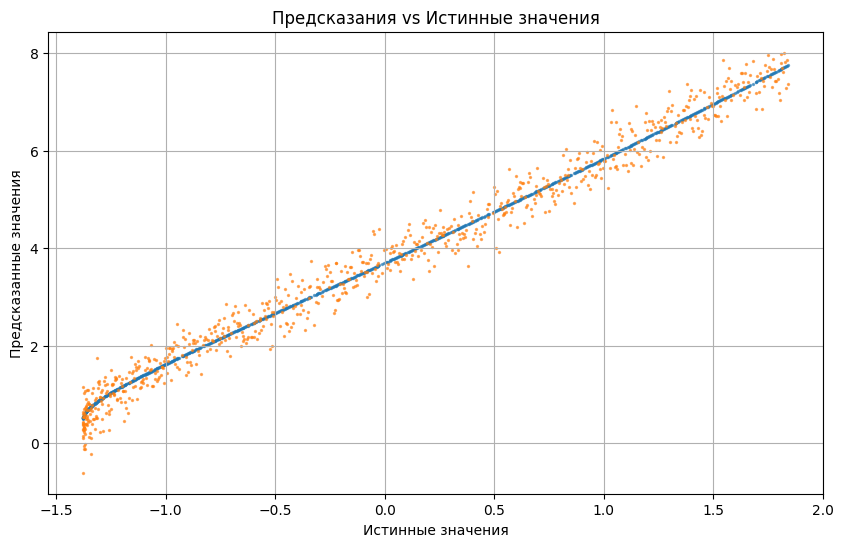

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(train[:, 0], model.predict(train), alpha=0.6, s=2)
plt.scatter(train[:, 0], target, alpha=0.6, s=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Предсказания vs Истинные значения')
plt.grid(True)
plt.show()

---

### Конец экспериментов

##### Сдача первой части соревнования
Загрузите файл `hw_final_closed_data.npy` (ссылка есть на странице с заданием). Если вы используете sklearn-совместимую модель, для генерации посылки вы можете воспользоваться функцией `get_predictions`. В ином случае перепишите функцию для вашей модели и запустите код под следующей ячейкой для генерации посылки.

In [ ]:
# !wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_yandex_ml_trainings/homeworks/assignment_final/hw_final_closed_data.npy -O hw_final_closed_data.npy

In [26]:
assert os.path.exists('hw_final_closed_data.npy'), 'Please, download `hw_final_closed_data.npy` and place it in the working directory'
closed_data = np.load('hw_final_closed_data.npy', allow_pickle=False)

Если необходимо, преобразуйте данные. Преобразованную матрицу объект-признак сохраните в переменную `closed_data`.

In [28]:
transformed_data = pipe.transform(closed_data)

In [29]:
def get_predictions(model, eval_data, step=10):
    predicted_values = model.predict(eval_data)
    return predicted_values

Обращаем ваше внимание, предсказания округляются до сотых!

In [30]:
predicted_values = np.round(get_predictions(model=model, eval_data=transformed_data), 2)

assert predicted_values.shape == (closed_data.shape[0], ) # predictions should be just one-dimensional array

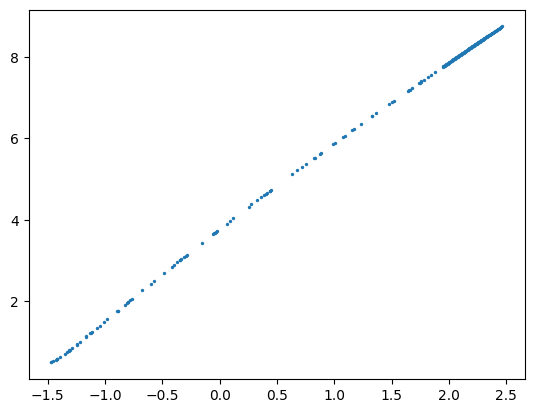

In [31]:
plt.scatter(transformed_data[:, 1], predicted_values, s=2)
plt.show()

In [33]:
# do not change the code in the block below
# __________start of block__________
def float_list_to_comma_separated_str(_list):
    _list = list(np.round(np.array(_list), 2))
    return ','.join([str(x) for x in _list])

submission_dict = {
    'predictions': float_list_to_comma_separated_str(predicted_values)
}
with open('submission_dict_final_p01.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
    
print('File saved to `submission_dict_final_p01.json`')
# __________end of block__________

File saved to `submission_dict_final_p01.json`


### Модель №2
Функция `my_transformation` принимает на вход матрицу объект-признак (`numpy.ndarray` типа `np.float`) и преобразует ее в новую матрицу. Данная функция может использовать только numpy-операции, а также арифметические действия.

Для примера доступна функция ниже. Она лишь добавляет новый признак, представляющий собой произведение первого и второго исходных признаков (считая с нуля).

In [34]:
def my_transformation(feature_matrix: np.ndarray):
    return pipe.transform(feature_matrix)

Обращаем ваше внимание, что параметры линейной модели будут округляться до __четырех знаков после запятой__. Это не должно сильно повлиять на качество предсказаний:

Параметры вашей модели:

In [36]:
w_list = list(np.round(model.coef_, 4))
print(f'w = {list(np.round(model.coef_, 4))}\nb = {np.round(model.intercept_, 4)}')

w = [np.float64(0.4031), np.float64(0.4202), np.float64(0.461), np.float64(0.4342), np.float64(0.4427)]
b = 3.7086


Напоминаем, ваша модель не должна использовать более 15 параметров (14 весов плюс свободный член).

In [37]:
assert len(w_list) + 1 <= 15

##### Сдача второй части соревнования
Для сдачи вам достаточно отправить функцию `my_transformation` и параметры вашей модели в контест в задачу №2. Пример посылки доступен ниже. Имортирование `numpy` также необходимо.

In [ ]:
# __________example_submission_start__________
import numpy as np

def my_transformation(feature_matrix):
    feature_matrix = np.delete(feature_matrix, [2, 6], axis=1)

    data_min_ = np.array([-0.56745416, -0.50726948, -0.44891025, -0.53678504, -0.36786881])
    data_max_ = np.array([-0.55991845,  1.25029283,  0.44817312, -0.47689872,  3.8536616])

    feature_matrix = (feature_matrix - data_min_) / (data_max_ - data_min_)

    best_poly = [
        np.float64(2.8958958958958956),
        np.float64(1.02002002002002),
        np.float64(1.1741741741741742),
        np.float64(1.970970970970971),
        np.float64(1.0)
    ]
    for i in range(5):
        feature_matrix[:, i] = np.sign(feature_matrix[:, i]) * (np.abs(feature_matrix[:, i]) ** best_poly[i])

    mean_ = np.array([0.42779629, 0.43060812, 0.45941949, 0.44224107, 0.44707574])
    scale_ = np.array([0.31092565, 0.29343886, 0.29345891, 0.30286409, 0.29209942])

    feature_matrix = (feature_matrix - mean_) / scale_

    return feature_matrix

w_submission = [0.4031, 0.4202, 0.461, 0.4342, 0.4427]
b_submission = 3.7086
# __________example_submission_end__________

array([[-1.33703898, -1.32772587, -1.3966559 , -1.3749883 , -1.36254745],
       [-0.61841751, -0.60666789, -0.569055  , -0.58983917, -0.58703242],
       [ 1.39965864,  1.42124339,  1.38394907,  1.39062268,  1.4030049 ],
       ...,
       [ 0.84285276,  0.80798554,  0.8258339 ,  0.83331559,  0.81639973],
       [ 0.21675552,  0.17143936,  0.22139794,  0.22032841,  0.1958221 ],
       [-1.16678866, -1.11656561, -1.13950186, -1.15571988, -1.12618933]],
      shape=(800, 5))

На этом задание завершено. Поздравляем!